In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

from scipy.special import gamma, loggamma, factorial

## load in the merger trees

In [5]:
def lnprob_i(N_real, n_i, sum_j):
    N_ratio = (N_real+1)/N_real
    fac1 = np.log(N_ratio)
    fac2 = np.log(N_real+1)
    return -(sum_j+1)*fac1 - n_i*fac2 + loggamma(sum_j+n_i+1) - loggamma(n_i+1) - loggamma(sum_j+1) # the version written in log space

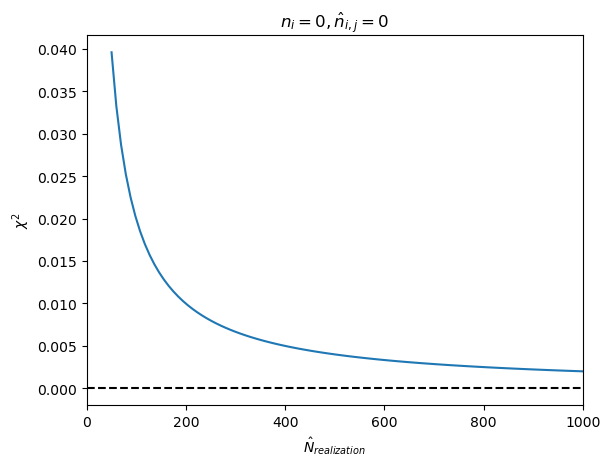

In [22]:
plt.title("$n_i = 0, \hat{n}_{i,j}=0$")
plt.plot(np.linspace(50,1000,100), -2*lnprob_i(np.linspace(50,1000,100), 0, 0))
plt.axhline(0, ls="--", color="k")
plt.ylabel("$\chi^2$")
plt.xlabel("$\hat{N}_{realization}$")
plt.xlim(0,1000)
plt.show()

In [ ]:
lgMh_models = np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"]
lgMh_models.shape

### create a single mock survey

In [ ]:
theta_fid = [10.5, 2.0, 0.2, 0, 0, 0]
lgMs_data = jsm_SHMR.general(theta_fid, lgMh_models[0], 0, 1) # just taking the first index!
plt.scatter(lgMh_models[0][0], lgMs_data[0])
plt.show()

In [ ]:
lgMh_models = np.delete(lgMh_models, 0, axis=0)
lgMh_models.shape # now I only have 99!

In [ ]:
N_bin = 31
nad_data = jsm_stats.SatStats_NAD_D(lgMs_data, min_mass=6.5, N_bin=N_bin)
nad_data.plot()

In [ ]:
my_data = jsm_stats.SatStats_D(lgMs_data, min_mass=6.5)
my_data.Pnsat_plot()
my_data.Msmax_plot()

## lets start by wokring with "perfect" models
#### $\theta_{Model} = \theta_{Data}$

In [ ]:
lgMs_models = np.apply_along_axis(jsm_SHMR.general, 0, theta_fid, lgMh_models, 0, 1) # converting the data using the same value of theta fid!
lgMs_models.shape

In [ ]:
nad_models = jsm_stats.SatStats_NAD_M(lgMs_models, min_mass=6.5, N_bin=N_bin)
nad_models.plot()

In [ ]:
my_models = jsm_stats.SatStats_M(np.vstack(lgMs_models), min_mass=6.5)
my_models.Pnsat_plot()
my_models.Msmax_plot()

#### measuring the log likelyhoods for the fiducial model (best case scenario)!

In [ ]:
nadler_best, nadler_lnPs = jsm_stats.lnL_Nadler(nad_data, nad_models)
print(nadler_best)

In [ ]:
my_best = -2*jsm_stats.lnL_JSM(my_data, my_models)
print(my_best)

### Now we can play with $\theta_{model}$!
#### Lets use $\Delta \chi^2 = \chi^2_i - \chi^2_{best}$   to compare

In [ ]:
def forward_nadler(theta, N_bin):
    nad_data = jsm_stats.SatStats_NAD_D(lgMs_data, min_mass=6.5, N_bin=N_bin) # have to redefine the data with new bins!
    lgMs_models = np.apply_along_axis(jsm_SHMR.general, 0, theta, lgMh_models, 0, 1) # converting the data using a new value of theta
    nad_models = jsm_stats.SatStats_NAD_M(lgMs_models, min_mass=6.5, N_bin=N_bin)
    return -2*jsm_stats.lnL_Nadler(nad_data, nad_models)

In [ ]:
def forward_JSM(theta):
    lgMs_models = np.apply_along_axis(jsm_SHMR.general, 0, theta, lgMh_models, 0, 1) # converting the data using a new value of theta
    my_models = jsm_stats.SatStats_M(np.vstack(lgMs_models), min_mass=6.5)
    return -2*jsm_stats.lnL_JSM(my_data, my_models)

#### first lets test the slope ($\alpha$)

In [ ]:
steps = 50
alphas = np.linspace(1.5, 3.5, steps)

nadler_chis_alpha = []
my_chis_alphas = []

for alpha in alphas:
    nadler_chis_alpha.append(forward_nadler([10.5, alpha, 0.2, 0, 0, 0], N_bin))
    my_chis_alphas.append(forward_JSM([10.5, alpha, 0.2, 0, 0, 0]))

In [ ]:
plt.plot(alphas, nadler_chis_alpha-nadler_best, color="red",ls="--", label="Nadler stats")
plt.plot(alphas, my_chis_alphas-my_best, color="black", label="our stats")
plt.xlabel("$\\alpha$", fontsize=15)
plt.ylabel("$\\Delta \\chi^2$")
plt.xlim(alphas.min(), alphas.max())
plt.axvline(2.0, color="grey", ls=":", label="truth")
plt.legend()
plt.show()

#### first lets test the scatter ($\sigma$)

In [ ]:
sigmas = np.linspace(0.1, 1.5, steps)
nadler_chis_sigma = []
my_chis_sigma = []

for sigma in sigmas:
    nadler_chis_sigma.append(forward_nadler([10.5, 2.0, sigma, 0, 0, 0], N_bin))
    my_chis_sigma.append(forward_JSM([10.5, 2.0, sigma, 0, 0, 0]))

In [ ]:
plt.plot(sigmas, nadler_chis_sigma-nadler_best, color="red",ls="--", label="Nadler stats")
plt.plot(sigmas, my_chis_sigma-my_best, color="black", label="our stats")
plt.xlabel("$\\sigma$", fontsize=15)
plt.ylabel("$\\Delta \\chi^2$")
plt.xlim(sigmas.min(), sigmas.max())
plt.axvline(0.2, color="grey", ls=":", label="truth")
plt.legend()
plt.show()

In [3]:
N_bin = 31
min_mass = 6.5
theta_fid = [10.5, 2, 0.2, 0, 0, 0]
data = jsm_models.INIT_DATA(theta_fid, "../../mcmc/Feature_Recovery/alpha_permutations/mock_1_test/mock_data.npy")
data.get_nad_stats(min_mass=min_mass, N_bin=N_bin)

In [4]:
models = jsm_models.LOAD_MODELS("../../../data/MW-analog/meta_data_psi3/", Nsamples=1)

def lnlike(theta):
    models.get_nad_stats(theta, min_mass, N_bin)
    return jsm_stats.lnL_Nadler(data, models)

In [5]:
lnlike(theta_fid)

-86.23986201594451